## Data Filtering stage

#### filter accident data based on available parameters.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30, 10)
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [2]:
df = pd.read_excel('../data/raw/data with translations.xlsx')
print(f"data shape: {df.shape}")
print(f"N accidents: {df.accident_id.nunique()}")

# initial data prep
int_to_str_cols_l = [
    "accident_id",
    "vehicle_id",
    "address_id"
]
for col in int_to_str_cols_l:
    df[col] = df[col].astype(str)
df.accident_date = pd.to_datetime(df.accident_date)

df.head()

data shape: (446264, 11)
N accidents: 175909


,compensation_status,accident_id,vehicle_id,fd_decision,circumstances,road_signs,road_surface,visibility,road_conditions,accident_date,address_id
0,VALIDATED_EIF,210,14.0,NG,NaN,NaN,NaN,NaN,NaN,2019-11-01 08:47:00+04:00,60
1,VALIDATED_EIF,210,13.0,FG,NaN,NaN,NaN,NaN,NaN,2019-11-01 08:47:00+04:00,60
2,VALIDATED_EIF,216,30.0,NG,NaN,NaN,NaN,NaN,NaN,2019-11-01 08:45:00+04:00,154
3,VALIDATED_EIF,216,29.0,FG,NaN,NaN,NaN,NaN,NaN,2019-11-01 08:45:00+04:00,154
4,VALIDATED_EIF,244,47.0,NG,NaN,NaN,NaN,NaN,NaN,2019-11-02 21:40:00+04:00,227


In [3]:
# filtering out those obseravtions that have full fill data
list_available_data = [
    df[~pd.isna(df.circumstances)].accident_id.unique(), 
    df[~pd.isna(df.road_conditions)].accident_id.unique(),
    df[~pd.isna(df.visibility)].accident_id.unique(),
    df[~pd.isna(df.road_surface)].accident_id.unique()
]
valid_data_accidents = set.intersection(*map(set,list_available_data))
print(f"We have {len(valid_data_accidents)} number of accidents with known circumstances, road_surface, visibility and road_conditions")

df_full = df[df.accident_id.isin(valid_data_accidents)]
print(df_full.shape)

We have 4217 number of accidents with known circumstances, road_surface, visibility and road_conditions
(18444, 11)


In [4]:
df_full.accident_date = pd.to_datetime(df_full.accident_date)

df_full.accident_date.describe()


count                         18444
unique                         4123
top       2020-05-06 12:00:00+04:00
freq                             26
first     2018-01-11 08:10:00+04:00
last      2021-07-19 01:40:00+04:00
Name: accident_date, dtype: object

In [5]:
df.accident_date.describe()

count                        446264
unique                       132253
top       2020-02-04 10:40:00+04:00
freq                             80
first     2012-10-20 17:36:00+04:00
last      2022-10-18 03:24:00+04:00
Name: accident_date, dtype: object

In [6]:
df_full.columns

Index(['compensation_status', 'accident_id', 'vehicle_id', 'fd_decision',
       'circumstances', 'road_signs', 'road_surface', 'visibility',
       'road_conditions', 'accident_date', 'address_id'],
      dtype='object')

In [7]:
df_full.to_csv('../data/interim/data_bivac_filtered.csv', index=False)

### Check number of vehicles accident - vise

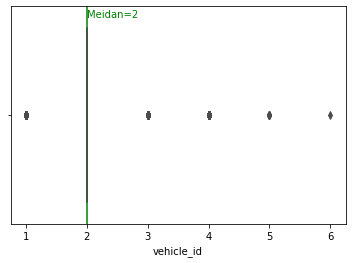

In [8]:
df_temp = df_full[["accident_id", "vehicle_id"]]\
            .groupby("accident_id")\
            .agg({'vehicle_id': ['nunique']})\
            .reset_index()
df_temp.columns = ["".join(col).strip().replace("nunique", "") for col in df_temp.columns.values]
median_ = int(df_temp.vehicle_id.quantile(0.5))
g = sns.boxplot(data=df_temp, x="vehicle_id", color="orange")
ymin, ymax = g.get_ylim()
g.vlines(x=median_, ymin=ymin, ymax=ymax, color="green")
g.text(x=median_, y=ymax-ymax*0.1, s=f"Meidan={median_}", color="green")
plt.show()

In [9]:
# what we do with accidents with one vehicle only?
df_temp.vehicle_id.value_counts()

2    3623
3     454
4      78
1      55
5       6
6       1
Name: vehicle_id, dtype: int64

### Check fd_decision status

In [10]:
del df_temp
df_temp = df_full[
    [
        "accident_id", 
        "vehicle_id", 
        "fd_decision"]
    ].groupby(["accident_id"]).agg({"vehicle_id": ["nunique"],
                                    "fd_decision": ["nunique"]})\
    .reset_index()\
    .sort_values(by=('vehicle_id', 'nunique'))
df_temp.columns = ["".join(col).strip().replace("nunique", "") for col in df_temp.columns.values]
df_temp

,accident_id,vehicle_id,fd_decision
3610,81212,1,1
654,140851,1,1
2661,58057,1,1
4038,93689,1,1
3767,84752,1,1
...,...,...,...
1796,31720,5,2
1956,35010,5,2
2390,49055,5,2
3158,69448,5,2


In [11]:
valid_acc_id_by_fd = df_temp[df_temp.fd_decision==2].accident_id.unique()
print(f"we have {len(valid_acc_id_by_fd)}/{df_full.accident_id.nunique()} number of valid fd_decision accidents")

we have 3993/4217 number of valid fd_decision accidents


In [12]:
print(f"we have {len(df_temp[(df_temp.vehicle_id==1) & (df_temp.fd_decision==1)])} number of accidents with 1 vehicle and 1 fd_decision")
print(f"we have {len(df_temp[df_temp.fd_decision>2])} number of accidents with more than 2 fd_decisions")

we have 55 number of accidents with 1 vehicle and 1 fd_decision
we have 0 number of accidents with more than 2 fd_decisions


### Check percentage of road_signs

In [13]:
df_full[~pd.isna(df_full.road_signs)].accident_id.nunique()

17